# Principal component analysis

Apziva project #4: "MonReader"<br>
2023 08 02

__Summary:__
* In this notebook, two transfer learning models Inception and MobileNet and the two squaring strategies are compared by __PCA bi-plots__.
* __Scree plots__ are used to estimate the range for __reasonable dimensionality reduction__ when including PCA in the training processes to follow.

## TOC: <a class="anchor" id="TOC"></a>
* [Utilities](#Utilities)
* [General settings](#GeneralSetting)
* [PCA](#PCA)    
    * [Bi-plots](#BiPlots)    
    * [Scree plot](#ScreePlot)    

## Utilities <a class="anchor" id="Utilities"></a>
[TOC](#TOC)

In [1]:
# own libraries
import Utilities as u
import MachineLearning as ml

# activate changes in libraries
import importlib
importlib.reload(u)
importlib.reload(ml)

# aliases
from Utilities import TypeChecker as t
from Utilities import PrintAlias as p

## General settings <a class="anchor" id="GeneralSetting"></a>
[TOC](#TOC)

In [2]:
# constants

# general
cfltRandomSeed = 42 # any number

# files
cstrDownloadRoot =         "../../OutsideRepository/ImagesRaw/"
cstrImagePreparationRoot = "../../OutsideRepository/ImagesProcessed/"

cdintSquareSides =            {"Inception":299,"MobileNet":224}

clstrTransferLearningModels = ["Inception","MobileNet"]
clstrSquaringStrategies     = ["Squeeze","Crop"]

clstrDownloadDatasets =       ["training","testing"]
clstrDownloadClasses  =       ["flip","notflip"]

clstrMLModels =               ["L2","Random Forest","SVM"]

## PCA <a class="anchor" id="PCA"></a>
[TOC](#TOC)

## Bi-Plots <a class="anchor" id="BiPlots"></a>
[TOC](#TOC)

BI-PLOTS
- by transfer learning model
- by squaring strategy
- legend:
  - green: notflip
  - orange: flip


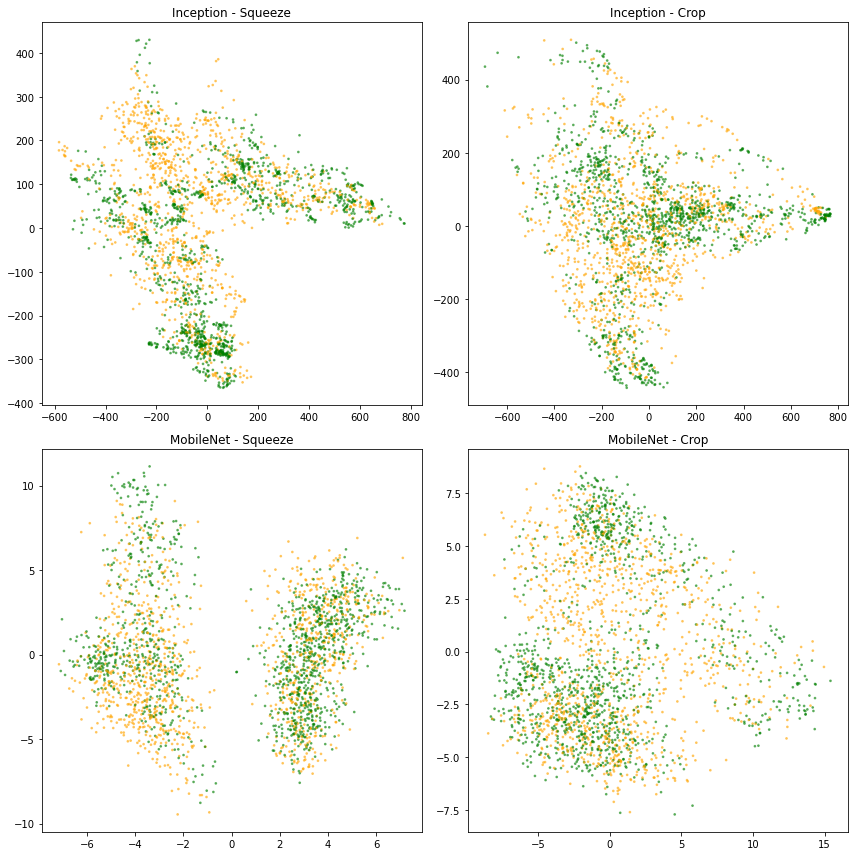

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# init
cfltMarkerSize = 3
ddafltX = {}

# get X_train data
for strModel in clstrTransferLearningModels:
    ddafltX[strModel] = {}
    for strSquaringStrategy in clstrSquaringStrategies:
        strPickleFile = f"../data/processed/{strModel}/{strSquaringStrategy}/X_train.p"
        ddafltX[strModel][strSquaringStrategy] = u.FromDisk(strPickleFile,strType="")  

# create a 2x2 subplot array
fig, axs = plt.subplots(2, 2, figsize=(12, 12))

# loop through each combination and perform PCA
for i, (strModel, dafltX) in enumerate(ddafltX.items()):
    for j, (strStrategy, X) in enumerate(dafltX.items()): 
        
        # get y for coloring
        strPickleFile = f"../data/processed/{strModel}/{strSquaringStrategy}/y_train.p"
        y = u.FromDisk(strPickleFile,strType="") 

        # perform PCA with n=2
        objPCA = PCA(n_components=2)
        a2fltTwoComponents = objPCA.fit_transform(X)  
        
        # shuffle the indices
        a1intIndices = np.arange(len(X))
        np.random.shuffle(a1intIndices)

        # scatterplots
        axs[i, j].scatter(a2fltTwoComponents[a1intIndices, 0], a2fltTwoComponents[a1intIndices, 1], 
                          c=['green' if intLabel == 0 else 'orange' for intLabel in y[a1intIndices]], alpha=0.5, s=cfltMarkerSize)
        axs[i, j].set_title(f'{strModel} - {strStrategy}')
        
# finalize
p("Bi-plots".upper())
p("- by transfer learning model")
p("- by squaring strategy")
p("- legend:")
p("  - green: notflip")
p("  - orange: flip")
plt.tight_layout()
plt.show()

__Observations:__
* None of the 4 combinations clearly separates a green cloud (notflip) from an orange cloud (flip).
* This does not mean that ML models cannot distinguish between the two target classes, but it may not be easy.
* The combination "MobileNet - Squeeze" splits the images into two islands, but they are not connected to flip/notflip.

## Scree plot <a class="anchor" id="ScreePlot"></a>
[TOC](#TOC)

SCREE PLOTS



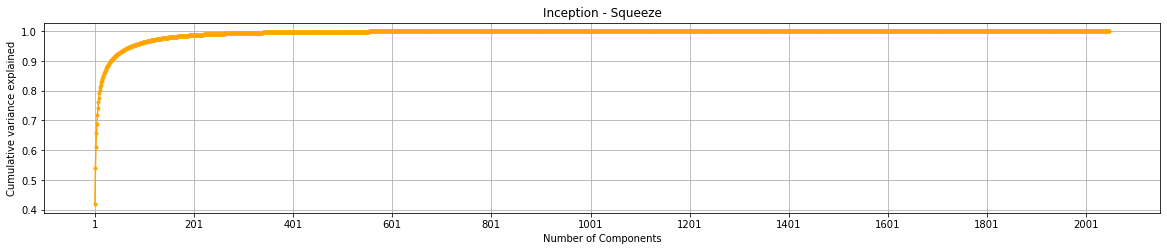

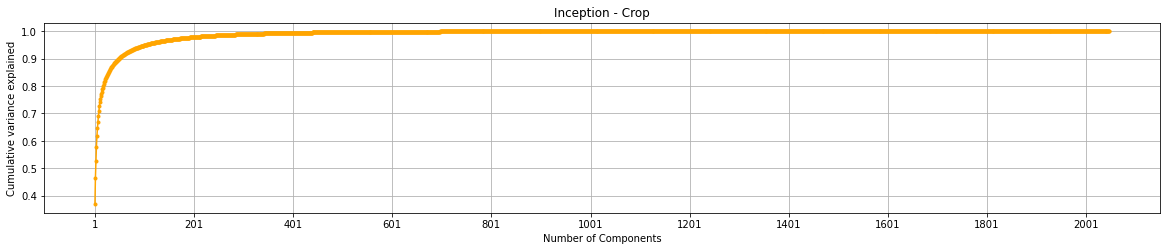

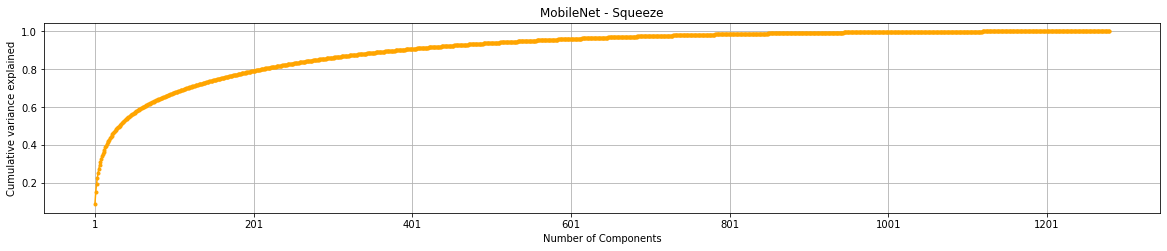

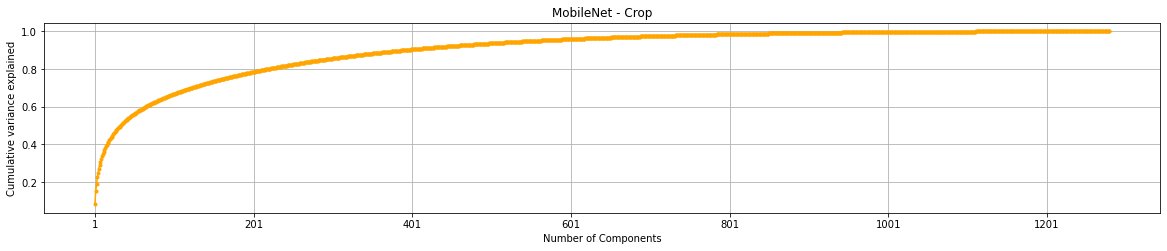

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# init
cintStepSizeHorizontalAxis = 200
p("Scree plots".upper())
p()

# loop through combinations
for strModel in clstrTransferLearningModels:
    for strSquaringStrategy in clstrSquaringStrategies:
        
        # get X data      
        strPickleFile = f"../data/processed/{strModel}/{strSquaringStrategy}/X_train.p"
        X_train = u.FromDisk(strPickleFile,strType="")  
        
        # scaling
        objScaler = StandardScaler()
        X_train_standardized = objScaler.fit_transform(X_train)

        # PCA
        objPCA = PCA()
        objPCA.fit(X_train_standardized)

        # cumulative variance explained
        a1fltCumulativeVarianceExplained = np.cumsum(objPCA.explained_variance_ratio_)

        # scree plot
        fltWidth=20
        fltHeight = 3.5
        plt.figure(figsize=(fltWidth, fltHeight))
        plt.plot(np.arange(1, len(a1fltCumulativeVarianceExplained) + 1), a1fltCumulativeVarianceExplained, marker='.',c="orange")
        plt.title(f"{strModel} - {strSquaringStrategy}")
        plt.xlabel('Number of Components')
        plt.ylabel('Cumulative variance explained')
        x_ticks = np.arange(1, len(a1fltCumulativeVarianceExplained) + 1, step=cintStepSizeHorizontalAxis)
        plt.xticks(x_ticks)
        plt.grid(True)
        plt.show()

__Comment:__
* The transfer-learning models are different: to explain __90% of the variance__ the models require different numbers of PCA components...
    * Inception: 50.
    * MobileNet: 400 PCA.
* As for the first two components, used in the bi-plots above:
    * For the compination __Inception - Crop__ they explain about __55% of the variance__.
    * This seems to correspond to the visual impression that, from all 4 combinations, the __Inception - Crop__ bi-plot __distinguishes best__ between the target classes.
    * In the other 3 combinations, they explain only about 15% to 47% of the variance, which is __not enough__ to detect the two target classes.

__Conclusions:__
* It is __reasonable to apply PCA__ before running ML models:
    * There is no absolute threat by the __curse of dimensionality__, although the records to features ratio is close to 1, with both transfer-learning models.
    * The models will run __faster__ with feewer features.
* The __grid-search range__ will run __from 2 to 400 components__.